<center><img src="../meta/TRAIDENT.png" width="210"/></center>

# PCA optimisation
---

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from concurrent.futures import ProcessPoolExecutor
from sklearn.decomposition import PCA
from tqdm import tqdm
from training_utils.preprocessing import *

In [3]:
zarrpath = "/idia/users/jdawson/transient/traident/datasets/obs-omcen/cubes/cube-1.zarr"
xrdata = xr.open_dataset(zarrpath, engine='zarr', chunks={})
cube = xrdata.cube

In [123]:
blockSize = 128
chunk = getChunkIndexed(cube, 0, 0, blockSize)[0]
print(f"chunk loaded with shape: {chunk.shape}")

chunk loaded with shape: (4144, 128, 128)


In [135]:
128 * 128

16384

In [103]:
def preprocess_chunk(chunk, sigma):
    # Known injection positions
    signal_coords = [(30, 100), (40, 40), (20, 100)]
    # Inject fake signals (you don't need to change these functions)
    chunk = inject_fake_signal(chunk, 30, 100, 3000, sigma, 16)
    chunk = inject_periodic_gaussian_signal(chunk, 40, 40, 0, sigma, 120, width=16)
    chunk = inject_periodic_gaussian_signal(chunk, 20, 100, np.pi, sigma, 120, width=8)
    # Compute autocorrelation and reshape
    autocorr_cube = fft_autocorr_chunk(chunk)
    autocorr_cube -= np.median(autocorr_cube, axis=(1, 2))[:, None, None]
    autocorr_cube[0, :, :] = 0
    # Flatten autocorr cube to (H*W, T)
    T, H, W = autocorr_cube.shape
    autocorr_cube = autocorr_cube.reshape(T, -1).T  # shape: (H*W, T)
    # Convert (y, x) to flat indices
    flat_indices = np.array([y * W + x for (y, x) in signal_coords])
    return autocorr_cube, flat_indices

In [104]:
def runPCAAnomalies(inputs, n_components=32):
    pca = PCA(n_components=n_components)
    pca.fit(inputs)
    # pca_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    PCA_dims = pca.transform(inputs)
    return pca, PCA_dims

def get_PCA_dists(PCA_dims):
    np.sqrt((PCA_dims**2).sum(1))
    return np.sqrt((PCA_dims**2).sum(1))

def get_reconstruction_loss(pca, dims, autocorr_cube):
    reconstructed = pca.inverse_transform(dims)
    return np.abs(reconstructed - autocorr_cube).sum(1)

In [129]:
#chunk, fake_indices = preprocess_chunk(chunk, 3)
components = np.arange(1,300,25)
avg, std, simulants, residuals = [],[],[],[]
normal_residuals, normal_residual_stds, normal_residuals_max = [], [], []
for component in tqdm(components):
    pca, PCA_dims = runPCAAnomalies(autocorr_cube, n_components=component)
    dists = get_PCA_dists(PCA_dims)
    avg.append(np.median(dists))
    std.append(np.std(dists))
    simulants.append((dists[fake_indices]-np.median(dists))/np.std(dists))
    residuals.append(get_reconstruction_loss(pca, PCA_dims[fake_indices], autocorr_cube[fake_indices]))
    all_normal_residuals = get_reconstruction_loss(pca, PCA_dims[~fake_indices], autocorr_cube[~fake_indices])
    normal_residuals.append(np.median(all_normal_residuals))
    normal_residual_stds.append(np.std(all_normal_residuals))
    normal_residuals_max.append(all_normal_residuals.max())


00%|██████████| 12/12 [01:43<00:00,  8.64s/it]

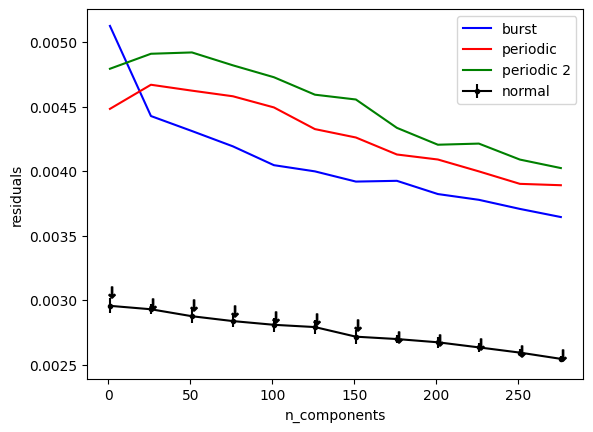

In [134]:
plt.figure()
plt.plot(components, np.array(residuals)[:,0], 'b-', label='burst')
plt.plot(components, np.array(residuals)[:,1], 'r-', label='periodic')
plt.plot(components, np.array(residuals)[:,2], 'g-', label='periodic 2')
plt.errorbar(x=components, y=normal_residuals, yerr=normal_residual_stds, color='k', marker='.', label='normal')
plt.plot(components, normal_residuals_max, color='k', marker=r'$\downarrow$', markersize=8, linestyle='None')
plt.xlabel('n_components')
plt.ylabel(r'residuals')
plt.legend()

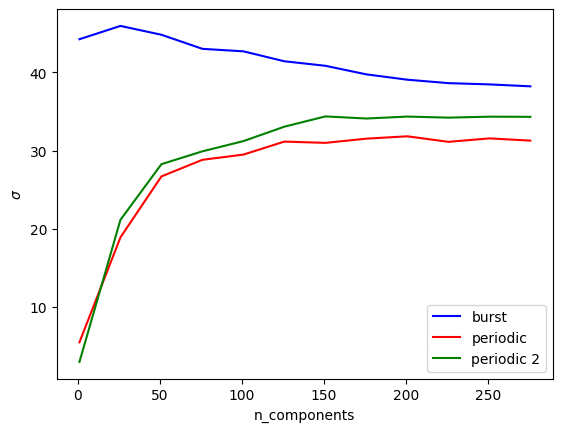

In [126]:
plt.figure()
plt.plot(components, np.array(simulants)[:,0], 'b-', label='burst')
plt.plot(components, np.array(simulants)[:,1], 'r-', label='periodic')
plt.plot(components, np.array(simulants)[:,2], 'g-', label='periodic 2')
plt.xlabel('n_components')
plt.ylabel(r'$\sigma$')
plt.legend()

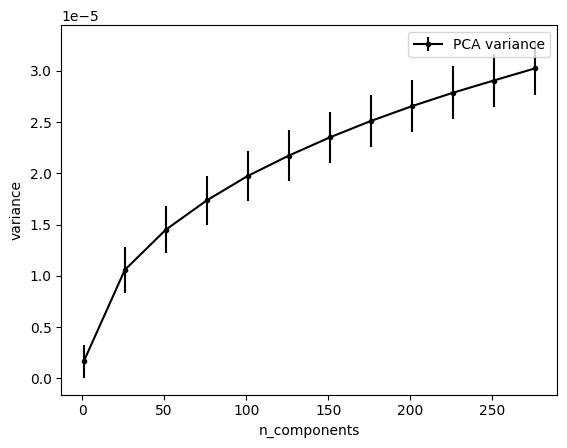

In [127]:
plt.figure()
plt.errorbar(x=components, y=avg, yerr=std, color='k', marker='.', label='PCA variance')
plt.xlabel('n_components')
plt.ylabel('variance')
plt.legend()

In [65]:
np.array(avg).shape

(13,)